# Non-Markovian Quantum Reservoir Computing

This notebook implements **quantum reservoir computing (QRC)** based on the Fujii-Nakajima approach, using MPS evolution.

## Architecture

1. **Input Layer**: Classical signal encoded into quantum system via time-dependent fields
2. **Reservoir**: Network of coupled spins with transverse-field Ising Hamiltonian
3. **Readout**: Linear regression on expectation values of Pauli operators

## Theory

**Reservoir Hamiltonian** (Fujii-Nakajima):
$$H(t) = H_{\text{res}} + H_{\text{input}}(t)$$

$$H_{\text{res}} = -J \sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z - h \sum_i \sigma_i^x$$

$$H_{\text{input}}(t) = \sum_i g_i u(t) \sigma_i^z$$

where:
- $J$ = coupling strength between neighboring spins
- $h$ = transverse field strength
- $g_i$ = input coupling coefficients
- $u(t)$ = input signal

**MPS**:
Quantum reservoir is made of MPS that represent a 1/2-spin system

In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra, Statistics
using ITensors, ITensorMPS
using Random

gr()      # Per GR backend


Plots.GRBackend()

In [2]:
"""
Ausiliary Functions
"""


function ridge_regression(X::AbstractMatrix, y::AbstractVector, alpha::Real; add_intercept::Bool=true)
    """
    Ridge regression (L2 regolarizzazione) da zero.
    
    Args:
        X: Matrice delle features
        y: Vettore target
        lambda: Parametro di regolarizzazione (>= 0)
        add_intercept: Se true, aggiunge colonna di 1
    """
    n, p = size(X)
    
    # Add intercept
    if add_intercept
        X_design = hcat(ones(n), X)
        p += 1
        gamma = diagm(vcat(0.0, fill(alpha, p-1)))
    else
        X_design = X
        gamma = alpha * I(p)
    end
    
    print(gamma)
    # ridge: β = (X'X + Γ)^(-1) X'y
    XtX = X_design' * X_design
    beta = inv(XtX + gamma) * (X_design' * y)
    
    #Separate coefficients and intercept
    if add_intercept
        intercept = beta[1]
        coef = beta[2:end]
    else
        intercept = 0.0
        coef = beta
    end
    
    
    return coef, intercept
end

function MSE(a::AbstractVector,b::AbstractVector)
    residuals = a - b
    mse = mean(residuals.^2)
    return mse
end

function NMSE(a::AbstractVector,b::AbstractVector)
    mse = MSE(a,b)
    variance = var(a)
    nmse = mse / variance
    return nmse
end

NMSE (generic function with 1 method)

In [3]:

struct QuantumReservoir
    N::Int16
    J::Float64
    h::Float64
    input_scaling::Float64
    washout::Int32
    s::Vector{Index{Int64}} # mps sites
end 

function input_hamiltonian(res::QuantumReservoir, u_t::Float64,dt)
    """
        Build input Hamiltonian: H_input(t) = sum_i g * u(t) * σ_i^x
    """
    N = res.N
    g = res.input_scaling
    h = res.h
    s = res.s

    gates = ITensor[]

    for j in 1:N
        hj = op("Sx",s[j])
        Gj = exp(-im * dt *(g * h * (u_t+1))* hj)
        push!(gates, Gj)
    end

    return gates
end

function reservoir_hamiltonian(res::QuantumReservoir,dt)
    """
        Build Reservoir Hamiltonian: H_input(t) = - J * sum_ij σ_i^z σ_j^z
    """
    N = res.N
    J = res.J
    h = res.h
    s = res.s

    gates = ITensor[]

    for j in 1:N-1
        hj = op("Sz", s[j]) * op("Sz", s[j+1]) 
        Gj = exp(-im * J * dt * hj)
        push!(gates, Gj)
    end 
    return gates
end

function one_step_evolution(res::QuantumReservoir, psi::MPS, u_t::Float64, res_ham::Vector{ITensor}, dt_inp)
    
    #inject input in transverse field
    H_inp = input_hamiltonian(res,u_t,dt_inp)
    psi = apply(H_inp, psi)

    #apply reservoir hamiltonian
    psi = apply(res_ham, psi)

    return psi
end

# process input sequence through reservoir
function process_input_seq(res::QuantumReservoir, input_seq::Vector{Float64}, dt_res, dt_inp)
    
    # create initial state
    psi = random_mps(res.s, linkdims=1)

    # define reservoir dynamics
    res_ham = reservoir_hamiltonian(res,dt_res)

    # input processind and features extraction
    features = []
    L = length(input_seq)
    for (i,u_t) in enumerate(input_seq)
        
        psi = one_step_evolution(res, psi, u_t, res_ham, dt_inp)
        normalize!(psi)
        
        # compute observables as features
        feature_step = expect(psi, "Sz")
        push!(features, feature_step)
        
        percent = (100 * i) ÷ L
        if percent % 10 == 0 
            println("Done: $(Int(percent))/100 input sequence")
        end
    end
    features = hcat(features...)'

    return features[res.washout + 1 : end, :]
end


process_input_seq (generic function with 1 method)

In [4]:
"""
TASK
"""


function generate_narma_p(n_samples, p, scale)
    """
    Generate NARMA-p time series.

    y(t+1) = 0.3*y(t) + 0.05*y(t)*sum_{i=0}^{p-1} y(t-i) + 1.5*u(t-(p+1))*u(t) + 0.1

    This is a standard benchmark for temporal processing systems.
    """

    function input_paper(N, a=2.11, b=3.73, c=4.11, T=100.0)
        t = 1:N
        u = 0.1 .* (sin.(2π .* a .* t ./ T) .* 
                    sin.(2π .* b .* t ./ T) .* 
                    sin.(2π .* c .* t ./ T) .+ 1.0)
        return u
    end



    # Input u(t), uniform in [0, scale]
    u = input_paper(n_samples+p) #rand(Float64, n_samples + p) .* scale
    y = zeros(n_samples + p)
    
    for t in p+1:length(y)           
        # sum of previous p values
        sum_prev = sum(y[t-p:t-1])   # y[t-p]..y[t-1]
        y[t] = 0.3*y[t-1] + 0.05*y[t-1]*sum_prev + 1.5*u[t-p]*u[t] + 0.1
    end
    
    return u[p+1:end], y[p+1:end]
end

generate_narma_p (generic function with 1 method)

In [19]:
"""
MAIN: process input through reservoir
"""

# initialize quantum reservoir
N = 4
J = 1.0
h = 0.1
input_scaling = 1
s = siteinds("S=1/2", N) # initialize sites
dt_res = 0.1
dt_inp = 0.1

washout = 20
n_train = 200
n_test = 50
T = washout + n_train + n_test

#####################################
QR = QuantumReservoir(N, J, h, input_scaling, washout, s)
res_ham = reservoir_hamiltonian(QR,dt_res)

# NARMA TASK
p = 1
scale = 1
u, y = generate_narma_p(T, p, scale) # select task here

u_full = u[washout+1 : end]
y_full = y[washout+1 : end]

u_train = u_full[begin : n_train]
y_train = y_full[begin : n_train]
u_test = u_full[n_train + 1 : end]
y_test = y_full[n_train + 1 : end]

input_seq = u  


# Process information
feat = process_input_seq(QR,input_seq,dt_res, dt_inp)

feat_train = feat[begin : n_train, :]
feat_test = feat[n_train + 1 : end, :];

Done: 0/100 input sequence
Done: 0/100 input sequence
Done: 10/100 input sequence
Done: 10/100 input sequence
Done: 10/100 input sequence
Done: 20/100 input sequence
Done: 20/100 input sequence
Done: 20/100 input sequence
Done: 30/100 input sequence
Done: 30/100 input sequence
Done: 30/100 input sequence
Done: 40/100 input sequence
Done: 40/100 input sequence
Done: 40/100 input sequence
Done: 50/100 input sequence
Done: 50/100 input sequence
Done: 50/100 input sequence
Done: 60/100 input sequence
Done: 60/100 input sequence
Done: 60/100 input sequence
Done: 70/100 input sequence
Done: 70/100 input sequence
Done: 70/100 input sequence
Done: 80/100 input sequence
Done: 80/100 input sequence
Done: 80/100 input sequence
Done: 90/100 input sequence
Done: 90/100 input sequence
Done: 90/100 input sequence
Done: 100/100 input sequence


In [20]:
"""
TRAIN LINEAR READOUT  y = w @ features
"""

alpha = 1e-8
coef, intercept = ridge_regression(feat_train, y_train, alpha)

y_pred_train = feat_train * coef .+ intercept

println("MSE:$(MSE(y_train,y_pred_train))" )
println("NMSE:$(NMSE(y_train,y_pred_train))" )

plt = plot(layout = (1,1), size=(1000,600), margin=5Plots.mm)

plot!(1:60, y_train, label = "Target")
plot!(1:60, y_pred_train, label = "Prediction")
title!(plt, "Training")
display(plt)

[0.0 0.0 0.0 0.0 0.0; 0.0 1.0e-8 0.0 0.0 0.0; 0.0 0.0 1.0e-8 0.0 0.0; 0.0 0.0 0.0 1.0e-8 0.0; 0.0 0.0 0.0 0.0 1.0e-8]MSE:0.00018751104779122292
NMSE:0.9686741259645493


print device already activated
print device already activated


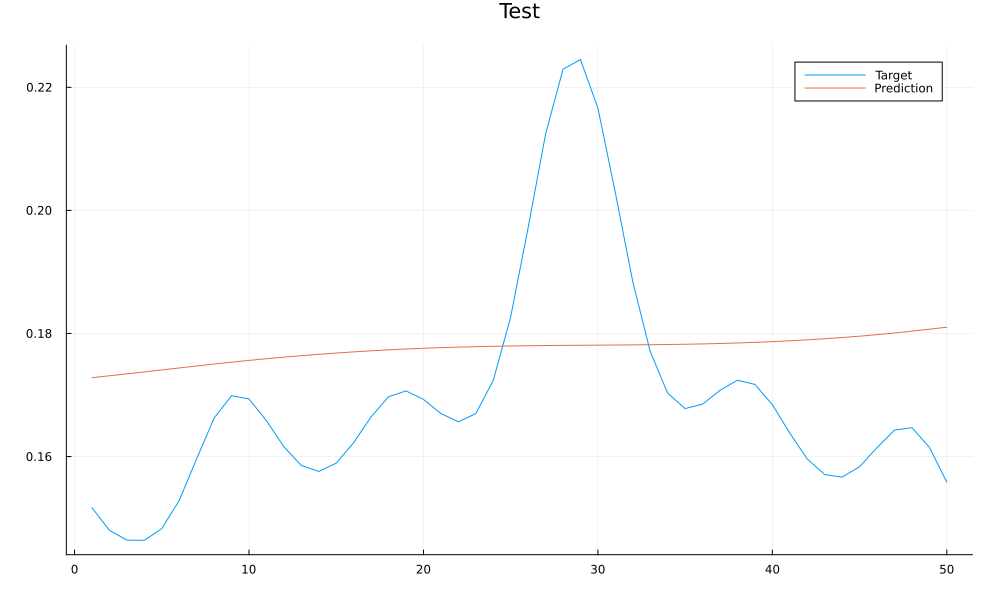

MSE:0.00037245080682908404
NMSE:1.1000853972226716


print device already activated


In [21]:
y_pred_test = feat_test * coef .+ intercept

println("MSE:$(MSE(y_test,y_pred_test))" )
println("NMSE:$(NMSE(y_test,y_pred_test))" )

plt2 = plot(layout = (1,1), size=(1000,600), margin=5Plots.mm)

plot!(1:n_test, y_test, label = "Target")
plot!(1:n_test, y_pred_test, label = "Prediction")
title!(plt2, "Test")
display(plt2)

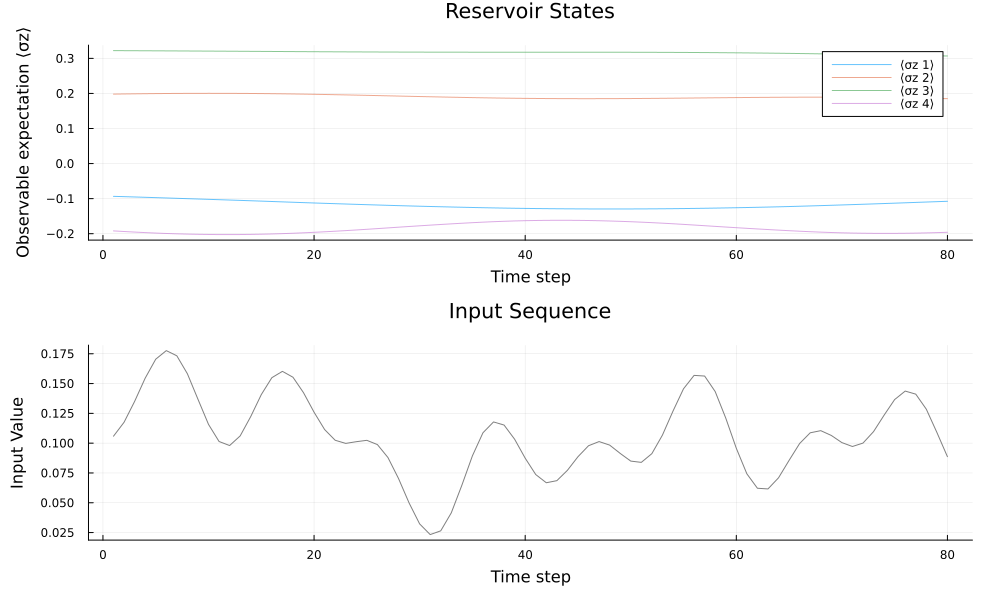

In [8]:

time_mask = 1:80
n_features_plot = 4  

plt = plot(layout = (2,1), size=(1000,600), margin=5Plots.mm)

for i in 1:n_features_plot
    plot!(
        plt[1],
        time_mask,
        feat[time_mask, i],
        alpha=0.6,
        grid=true,
        label= "⟨σz $i⟩"
    )
end

title!(plt[1], "Reservoir States")
xlabel!(plt[1], "Time step")
ylabel!(plt[1], "Observable expectation ⟨σz⟩")

plot!(plt[2], 
        time_mask,
        input_seq[time_mask],
        color=:grey,
        legend = false)

title!(plt[2], "Input Sequence")
xlabel!(plt[2], "Time step")
ylabel!(plt[2], "Input Value")


display(plt)

Initial trace distance: 0.993592
t=20: trace distance = 0.993592
t=40: trace distance = 0.993592
t=60: trace distance = 0.993592
t=80: trace distance = 0.993592
t=100: trace distance = 0.993592
t=120: trace distance = 0.993592
t=140: trace distance = 0.993592

Final trace distance: 0.993592
Echo state property: NOT SATISFIED ✗


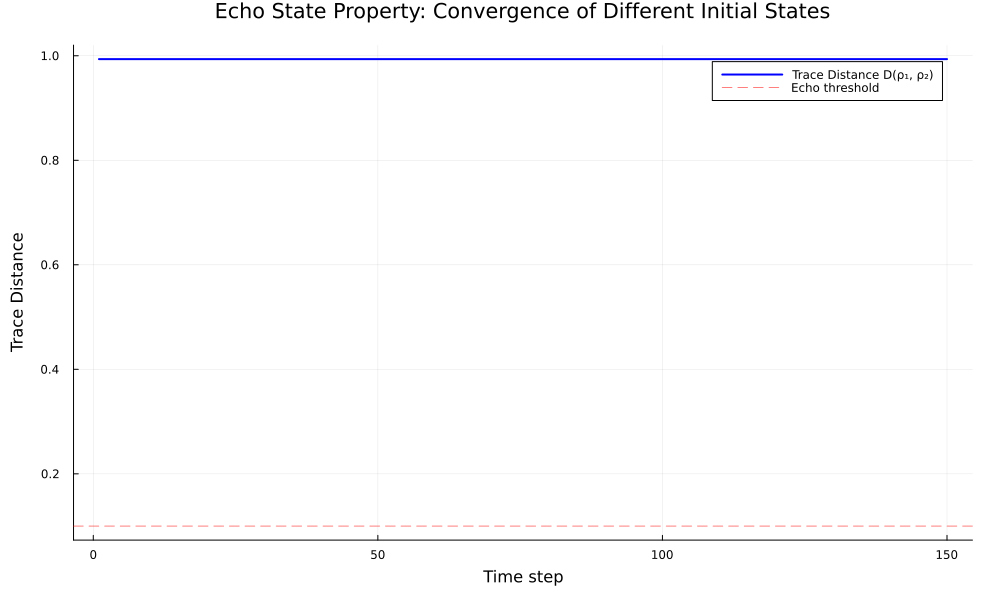

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


In [22]:
"""
ECHO STATE PROPERTY CHECK
Verify that different initial states converge to the same reservoir dynamics
"""

function compute_density_matrix(psi::MPS)
    """
    Compute the density matrix ρ = |ψ⟩⟨ψ| from MPS state
    Returns the reduced density matrix as ITensor
    """
    N = length(psi)
    # For pure state: ρ = |ψ⟩⟨ψ|
    # We compute this by contracting the MPS with its conjugate
    rho = outer(psi', dag(psi))
    return rho
end

function trace_distance(psi1::MPS, psi2::MPS)
    """
    Compute trace distance between two pure states:
    D(ρ1, ρ2) = 1 - |⟨ψ1|ψ2⟩|²
    
    For pure states, this simplifies to measuring overlap
    """
    overlap = inner(psi1, psi2)
    fidelity = abs(overlap)^2
    distance = 1.0 - fidelity
    return distance
end

function evolve_and_measure_distances(res::QuantumReservoir, input_seq::Vector{Float64}, 
                                       psi1_init::MPS, psi2_init::MPS, 
                                       dt_res, dt_inp)
    """
    Evolve two different initial states with the same input sequence
    and measure trace distance at each timestep
    """
    N = res.N
    res_ham = reservoir_hamiltonian(res, dt_res)
    
    # Copy initial states
    psi1 = copy(psi1_init)
    psi2 = copy(psi2_init)
    
    distances = Float64[]
    times = Int[]
    
    for (t, u_t) in enumerate(input_seq)
        # Evolve both states with same input
        psi1 = one_step_evolution(res, psi1, u_t, res_ham, dt_inp)
        psi2 = one_step_evolution(res, psi2, u_t, res_ham, dt_inp)
        
        normalize!(psi1)
        normalize!(psi2)
        
        # Compute trace distance
        dist = trace_distance(psi1, psi2)
        push!(distances, dist)
        push!(times, t)
        
        if t % 20 == 0
            println("t=$t: trace distance = $(round(dist, digits=6))")
        end
    end
    
    return times, distances
end

# Generate test input sequence
n_steps = 150
u_test_echo = generate_narma_p(n_steps, 1, 0.2)[1]

# Create two different initial states
psi_init_1 = random_mps(s, linkdims=2)  # Random state 1
psi_init_2 = random_mps(s, linkdims=2)  # Random state 2

# Check initial distance
initial_dist = trace_distance(psi_init_1, psi_init_2)
println("Initial trace distance: $(round(initial_dist, digits=6))")

# Evolve and measure
times, distances = evolve_and_measure_distances(QR, u_test_echo, psi_init_1, psi_init_2, dt_res, dt_inp)

# Plot results
plt_echo = plot(size=(1000,600), margin=5Plots.mm)
plot!(times, distances, 
      linewidth=2, 
      label="Trace Distance D(ρ₁, ρ₂)",
      color=:blue,
      xlabel="Time step",
      ylabel="Trace Distance",
      title="Echo State Property: Convergence of Different Initial States",
      legend=:topright,
      grid=true)

# Add reference line for echo state threshold
hline!([0.1], linestyle=:dash, color=:red, label="Echo threshold", alpha=0.5)

println("\nFinal trace distance: $(round(distances[end], digits=6))")
println("Echo state property: $(distances[end] < 0.1 ? "SATISFIED ✓" : "NOT SATISFIED ✗")")

display(plt_echo)